# Mod6L5 Data Challenge — Interpreting SLR Output (Dec 2023 NYC Taxi)


**Format:** We Do (Instructor prompts) → You Do (Student work) → We Share (reflection)


**Goal:** Choose **one** dependent variable (**Y**) from the taxi dataset and build **three** simple linear regressions (each with a different single **X**) on **Dec 2023** rides. For each model, interpret the **coefficient**, **intercept**, **p‑value**, and **R‑squared** in plain business language. Then decide which model is “better” *for decision‑making* and why.


> **Reminder:** No train/test split or advanced metrics today. We focus on reading `.summary()` and communicating results.

## Instructor Section (10 mins)

**Follow these steps/considerations as you work**


1) **Pick a useful Y.** Which outcome would someone actually act on?  Who is the stakeholder for your Y?

*Avoid constructing Y that bakes in your X (e.g., avoid using `fare_amount` as X when Y = `total_amount` which already includes fare).*


2) **Choose three X’s** you can know at decision time, and that plausibly relate to Y. 

*You may engineer a feature to use in the model if you like*

*Note:  SLR needs numeric only inputs so variables like `PULocationID` can't be used (categorical → not for SLR today unless you transform; stick to numeric X for this exercise)*


3) **Interpretation lenses:**
- **Units:** Always state slope in units (e.g., “per mile”, “per minute”).
- **p‑value:** Does evidence suggest the slope ≠ 0?
- **R²:** How much of Y’s variation is captured by this X? Does that help the decision?
- **Intercept:** Is X=0 meaningful? If not, say it’s a math anchor.
- **Plausibility:** Does the direction/size make sense (e.g., longer trip → higher fare)?


4) **Better ≠ only higher R².** Weigh **interpretability**, **actionability**, and **evidence** (p‑value, CI) alongside R².

## YOU DO (40 mins)

### Step 1: Read in the Data & Choose your **Y** (dependent variable)

Pick one from the 2023_Yellow_Taxi_Trip_Data_20251015 csv file  

In [4]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("/Users/ayemaq/Desktop/marcy_lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv", low_memory=False)

##### Recap: 
- In SLR, you model how one numeric value (X) helps explain OR predict another numeric variable (Y) 
    - **Y (Dependent variable)** is the outcome you're trying to understand or predict 
        - “What’s the result I care about?” or “What decision depends on this?”
    - **X (Independent variable)** is the factor that might influence or help explain Y 
        - "What might cause or be related to that outcome?"

#### My case 
The longer you travel, how likely are you to have to pay for tolls? As trip distance increases, do toll charges tend to increase?
- Y would be the toll amount
- x would be trip distance

My thoughts: I think as trip distance increases (it can depend on borough too), the amount of tolls increase esp if you are traveling between manhattan 

In [5]:
# explore the data
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0,0.69,1.0,N,141,140,1,7.9,2.5,0.5,3,0.0,1.0,17.4,2.5,0.0
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0,1.1,1.0,N,236,263,2,10,5.0,0.5,0,0.0,1.0,16.5,2.5,0.0
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,-10.7,-2.5,-0.5,0,0.0,-1.0,-17.2,-2.5,0.0
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0,1.57,1.0,N,48,239,4,10.7,2.5,0.5,0,0.0,1.0,17.2,2.5,0.0
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0,3,1.0,N,164,211,1,21.9,5.0,0.5,3,0.0,1.0,31.4,2.5,0.0


### Step 2: Propose three candidate **X** predictors (numeric)

Pick three different X columns that are **numeric** and **known at decision time**.

#### My answer:
1. trip_distance
    - Longer trips might cross tolled routes - logical predictor
2. airport_fee
    - Some airport trips (e.g., JFK, LGA) involve tolled bridges/tunnels
3. congestion_surcharge
    - Captures location/time patterns (like Manhattan zones) 
    - note to self: It's a flat fee the city adds to taxi rides that go through congestion zones — mostly parts of Manhattan below 96th Street.

### Step 3: Fit three one‑variable models with the SAME Y and different Xs

- run three simple linear regressions (SLRs); one for each of my chosen predictors (X variables) to see how each one individually relates to my Y (tolls_amount).

In [8]:
df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance             object
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount               object
extra                    float64
mta_tax                  float64
tip_amount                object
tolls_amount             float64
improvement_surcharge    float64
total_amount              object
congestion_surcharge     float64
airport_fee              float64
dtype: object

In [9]:
# convert trip distance into numeric
df['trip_distance'] = pd.to_numeric(df['trip_distance'], errors='coerce')   

In [11]:
# drop missing or infinite values only in the columns we care about
df_clean = df[['tolls_amount', 'trip_distance', 'airport_fee', 'congestion_surcharge']].replace([np.inf, -np.inf], np.nan).dropna()

# now run the models on df_clean
model1 = sm.OLS(df_clean['tolls_amount'], sm.add_constant(df_clean['trip_distance'])).fit()
model2 = sm.OLS(df_clean['tolls_amount'], sm.add_constant(df_clean['airport_fee'])).fit()
model3 = sm.OLS(df_clean['tolls_amount'], sm.add_constant(df_clean['congestion_surcharge'])).fit()


In [20]:
print("Model 1: trip_distance")
model1.summary()

Model 1: trip_distance


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           tolls_amount   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                 2.042e+06
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:31:54   Log-Likelihood:            -6.1800e+06
No. Observations:             3133519   AIC:                         1.236e+07
Df Residuals:                 3133517   BIC:                         1.236e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.4472      0.001   -367.502      0.000      -0.450      -0.445
trip_distance     0.3111      0.000   1429.152      0.000       0.311       0.312
==============================================================================
Omnibus:                  1739276.630   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      71205361595.645
Skew:                           0.525   Prob(JB):                         0.00
Kurtosis:                     741.491   Cond. No.                         7.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Coef for trip_distance is 0.3111
- This means for every 1 mile, the tolls_amount increases by ~$0.31 
- This is my slope (B1)

The p<0.5, so this relationship is statistically significant 
- We're confident that distance related to tolls, it isn't by random noise. 

R-squared = 0.395
- That means about 39.5% of the variation in toll costs can be explained by distance.

const = -0.4472
- If the trip is distance were 0, aka you didn't go on a trip, the expected toll would be -.4472 ... doesn't really make sense in this case 

CI: Airport_fee 0.311	0.312
- We are 95% confident that each additional mile of trip distance increases tolls by between $0.311 and $0.312.

Summary: Every extra mile is linked with an average toll increase of about $0.31, and this relationship is statistically significant. Distance alone explains roughly 40% of the variation in toll costs.

In [21]:
print("Model 2: airport_fee")
model2.summary()

Model 2: airport_fee


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           tolls_amount   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                 8.824e+05
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:40:00   Log-Likelihood:            -6.5776e+06
No. Observations:             3133519   AIC:                         1.316e+07
Df Residuals:                 3133517   BIC:                         1.316e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2801      0.001    241.564      0.000       0.278       0.282
airport_fee     2.1840      0.002    939.363      0.000       2.179       2.189
==============================================================================
Omnibus:                  3777024.636   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1695402383.965
Skew:                           6.012   Prob(JB):                         0.00
Kurtosis:                     116.317   Cond. No.                         2.14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Coef: 2.1840 -> a positive slope B1
- For every additional airport fee charged (i.e., airport trips), the expected toll cost increases by about $2.18.

P<.05: This is statistically significant. 
- We are confdient that airport fees is related to toll amounts

R-squared is .220 which is 22% 
- About 22% of the variation in the toll costs can be explained by airport_fees (possibly due to the routes you have to take to get to the airpot?)

const: .2801
- If a trip had no airport fee, the model predicts tolls around $0.28 on average (basically negligible tolls).

CI: airport_fee   2.179   2.189
- We are 95% confident that taking an airport trip increases toll costs by between $2.179 and $2.189 on average
- We can be very sure the average toll increase for airport trips is around $2.18, it might wiggle a few cents up or down, but not much

Summary: On average, airport trips are associated with about $2.18 higher toll costs, and this relationship is statistically significant. Around 22 % of differences in toll costs can be explained by whether the ride includes an airport fee—likely because routes to airports often pass through tolled crossings.  

In [22]:
print("Model 3: congestion_surcharge")
model3.summary()

Model 3: congestion_surcharge


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           tolls_amount   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                 3.491e+04
Date:                Tue, 28 Oct 2025   Prob (F-statistic):               0.00
Time:                        13:04:46   Log-Likelihood:            -6.9490e+06
No. Observations:             3133519   AIC:                         1.390e+07
Df Residuals:                 3133517   BIC:                         1.390e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.2382      0.004    330.623      0.000       1.231       1.246
congestion_surcharge    -0.2904      0.002   -186.854      0.000      -0.293      -0.287
==============================================================================
Omnibus:                  3364589.986   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        670700822.960
Skew:                           5.107   Prob(JB):                         0.00
Kurtosis:                      73.941   Cond. No.                         8.30
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Coef: It is a negative slope (B1) of -.2904
- For every extra dollar of congestion surcharge, tolls decrease by about $0.29. That’s unexpected, they move in opposite directions.

p<.05
- Statistically, the slope isn’t random , it’s a real (but weak) relationship. 
    

R-squared is .011, about 1.1%
- Only about 1.1% of toll variation is explained by congestion surcharge. So this model barely explains tolls.

const: 1.2382
- When there’s no congestion surcharge, the model predicts tolls of about $1.24 on average.

CI: -0.293	-0.287
- We’re 95% confident the true effect is between -$0.293 and -$0.287 per surcharge dollar.
- In other words, For every extra dollar of congestion surcharge, tolls go down by $0.29.

Summary: The model shows a small but statistically significant negative relationship between congestion surcharge and toll costs (slope = -0.29, p < 0.05). However, this likely reflects geography rather than a causal link: Manhattan trips usually include congestion fees but no tolls, while trips to outer boroughs include tolls but no congestion fees. This model explains only about 1% of variation in tolls, making it the weakest predictor compared to trip distance and airport fees.

### Step 4: Visual check for the “best” model candidate

Pick the model you currently prefer (based on business sense + evidence).
- Create a scatter of X vs. Y with the fitted line.

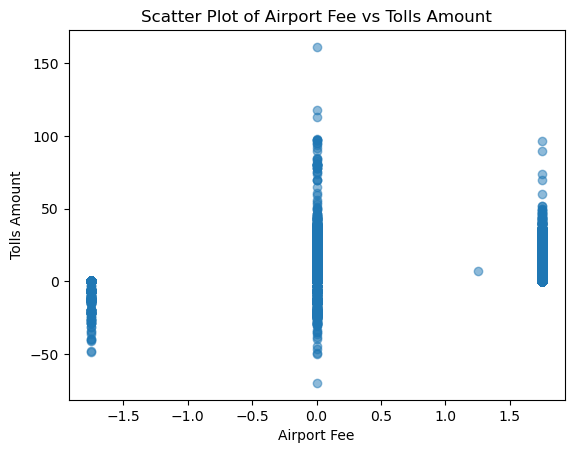

In [23]:
# I will create a scatter plot for airport_fees and tolls_amount
import matplotlib.pyplot as plt
plt.scatter(df_clean['airport_fee'], df_clean['tolls_amount'], alpha=0.5)
plt.xlabel('Airport Fee')           
plt.ylabel('Tolls Amount')
plt.title('Scatter Plot of Airport Fee vs Tolls Amount')
plt.show()

2 main vertical clusters


0 is no airport fee, 
- Trips with no airport fee (0) have a lot of variation, many are at $0 tolls, but a few go up to $100+ (long-distance, probably bridge/tunnel trips).

One around 1.25–1.75 (airport fee applied, depending on airport type)
- Trips with an airport fee tend to have higher toll amounts on average, but still some variation (different routes to JFK, LGA, etc.).


Those negative values almost always mean data errors or weird adjustments in the raw NYC Taxi dataset.


/var/folders/v2/9k8drrwj5h39kpr935vvx6j80000gn/T/ipykernel_27118/1523938875.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model2.params[0] + model2.params[1] * line


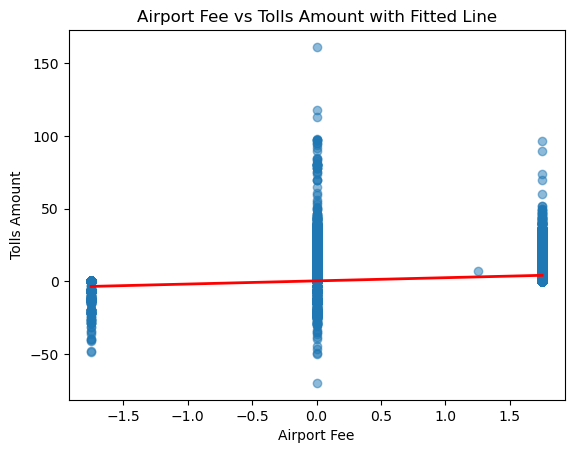

In [24]:
import numpy as np

X = df_clean['airport_fee']
y = df_clean['tolls_amount']
line = np.linspace(X.min(), X.max(), 100)
y_pred = model2.params[0] + model2.params[1] * line

plt.scatter(X, y, alpha=0.5)
plt.plot(line, y_pred, color='red', linewidth=2)
plt.xlabel('Airport Fee')
plt.ylabel('Tolls Amount')
plt.title('Airport Fee vs Tolls Amount with Fitted Line')
plt.show()


### Step 5: Interpret Each Model (write in plain English)
Fill the three blocks below. Use **units** and **percentage points (pp)** where relevant.

- **Slope (β₁):** “For each +1 unit of X, Y changes by …”`
- **Intercept (β₀):** meaningful or just a math anchor? Explain.
- **p‑value:** is there evidence the slope ≠ 0?
- **R²:** how much variation does this X explain?
- **Judgment:** is the effect size **practically** meaningful (tie to business)?

### Model A — Y = {{Toll_amount}} ~ X1 = {{trip_distance}}
- Slope (β₁): 0.311
- Intercept (β₀): -0.447
- p-value (slope): < 0.001
- 95% CI for slope: [0.311, 0.312]
- R²: 0.395
- Business readout (units): For every additional mile traveled, the average toll cost increases by about $0.31.
- One limitation: Some long trips have no tolls, and some short ones do—so distance alone doesn’t perfectly predict tolls (route matters).

### Model B — Y = {{toll_amount}} ~ X2 = {{airport_fee}}
- Slope (β₁): 2.184
- Intercept (β₀): 0.280
- p-value (slope): < 0.001
- 95% CI for slope: [2.179, 2.189]
- R²: 0.220
- Business readout (units): Airport trips are associated with about $2.18 higher toll costs on average.
- One limitation: The model doesn’t capture which airport or route is used, so toll amounts vary even among airport trips.

### Model C — Y = {{toll_amount}} ~ X3 = {{congestion_surcharge}}
- Slope (β₁): –0.290
- Intercept (β₀): 1.238\
- p-value (slope): < 0.001
- 95% CI for slope: [–0.293, –0.287]
- R²: 0.011
- Business readout (units): Trips with congestion surcharges tend to have $0.29 lower tolls, likely because these rides occur mostly within Manhattan where tolls aren’t charged.
- One limitation: The negative relationship isn’t causal—it reflects Manhattan trip patterns, not a real decrease in tolls.

## We Share (10 mins) — Reflection & Decision (write 1-2 short paragraphs)

1) **Which model is “better” for a stakeholder decision and why?**
- Weigh **evidence** (p‑value, CI), **explanatory power** (R²), **interpretability**, and **business impact** (units, MDE if relevant).
2) **What would you do next week to strengthen trust in this model?**
- (Preview) time‑based validation, hold‑out testing, segment checks, adding more plausible X’s, checking assumptions.